In [ ]:


import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

from keras.applications import vgg16 as trained_model
from keras.preprocessing.image import load_img, img_to_array
from keras import backend as K
import warnings
warnings.warn('my warning')

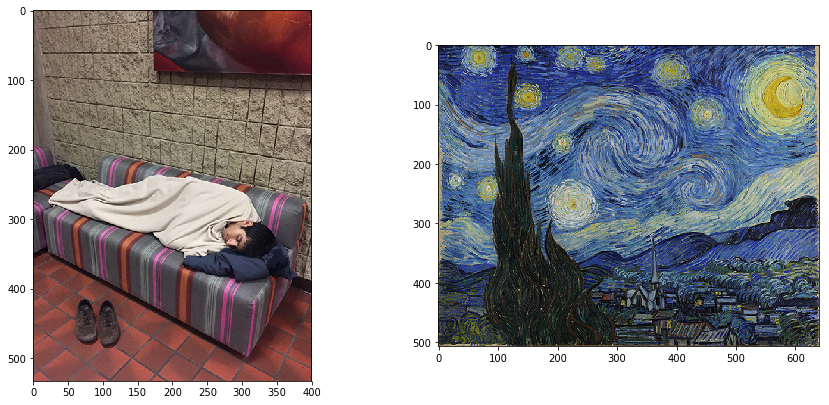

In [41]:
base_image_path = 'Data/content.jpg'
style_reference_image_path = 'Data/style.jpg'

width, height = load_img(base_image_path).size
img_rows = 400
img_cols = 600
img_channels = 3

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
img = load_img(base_image_path)
plt.imshow(img)
plt.subplot(2, 2, 2)
img = load_img(style_reference_image_path)
plt.imshow(img)
plt.show()

In [44]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_rows, img_cols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = trained_model.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((img_rows, img_cols, img_channels))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [45]:
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_rows, img_cols, 3))
input_tensor = K.concatenate([base_image, style_reference_image, combination_image], axis=0)

In [46]:
model = trained_model.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
model_dict = dict([(layer.name, layer.output) for layer in model.layers])


In [47]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_rows * img_cols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def content_loss(base, combination):
    return K.sum(K.square(combination - base))

def total_variation_loss(x):
    a = K.square(x[:, :img_rows - 1, :img_cols - 1, :] - x[:, 1:, :img_cols - 1, :])
    b = K.square(x[:, :img_rows - 1, :img_cols - 1, :] - x[:, :img_rows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [48]:
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.25
n_iterations = 10

In [49]:
loss = K.variable(0.)
layer_features = model_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features, combination_features)

feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
for layer_name in feature_layers:
    layer_features = model_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

In [50]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_rows, img_cols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Iteration 0: loss value 3056031232.0


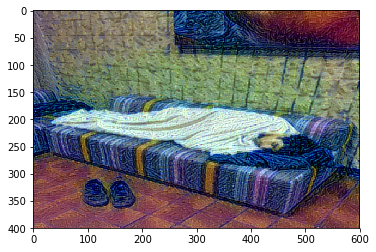

Iteration 1: loss value 2458681344.0


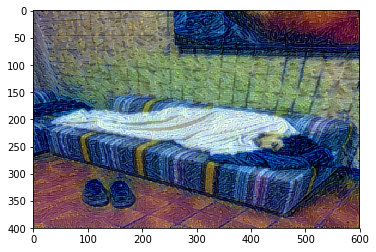

Iteration 2: loss value 2317290496.0


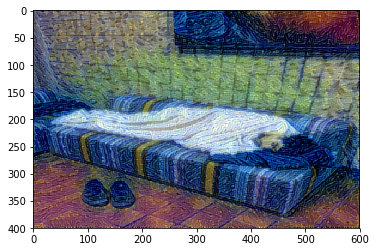

Iteration 3: loss value 2257357312.0


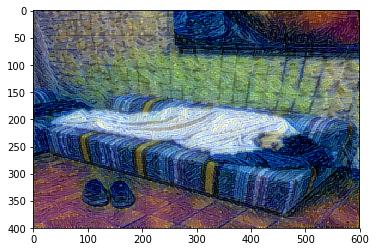

Iteration 4: loss value 2219358720.0


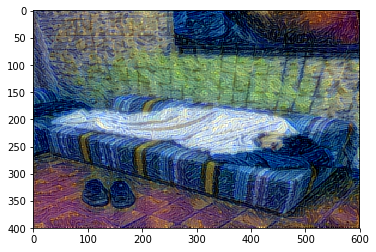

Iteration 5: loss value 2193494272.0


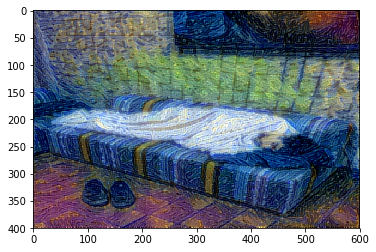

Iteration 6: loss value 2171496192.0


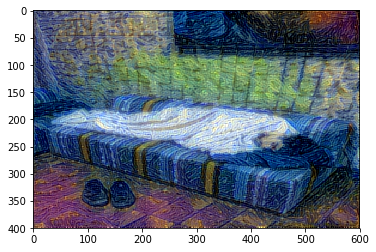

Iteration 7: loss value 2155721472.0


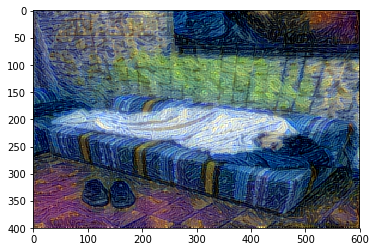

Iteration 8: loss value 2143068800.0


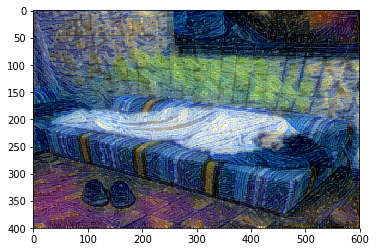

In [ ]:
x = preprocess_image(base_image_path)

for i in range(n_iterations):
    x, min_val, _ = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Iteration {}: loss value {}'.format(i, min_val))
    img = deprocess_image(x.copy())
    plt.imshow(img)
    plt.show()